### Dependencies

In [1]:
import torch
import torchvision
from PIL import Image
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np
from skimage.feature import peak_local_max

### COCO Names

In [2]:
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Pascal to coco converter
pascal_to_coco = {
    "aeroplane": "airplane",
    "bicycle": "bicycle",
    "bird": "bird",
    "boat": "boat",
    "bottle": "bottle",
    "bus": "bus",
    "car": "car",
    "cat": "cat",
    "chair": "chair",
    "cow": "cow",
    "diningtable": "dining table",
    "dog": "dog",
    "horse": "horse",
    "motorbike": "motorcycle",
    "person": "person",
    "pottedplant": "potted plant",
    "sheep": "sheep",
    "sofa": "couch",
    "train": "train",
    "tvmonitor": "monitor"
}

### Setting up model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Function for model prediction

In [4]:
# Function for prediction
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)

    return boxes, classes, labels, indices

### Function for fasterrcnn reshape transform

In [5]:
def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

### Function for visualizing cam

In [6]:
def visualize_cam(grayscale_cam, input_image):
    fig, axs = plt.subplots(1,2)

    # Grayscal cam
    axs[0].imshow(grayscale_cam, cmap="jet")
    
    # Overlayed cam
    image_float_np = np.float32(input_image) / 255
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

    axs[1].imshow(cam_image)

### Function for finding the max points

In [7]:
# def find_max_points(img_array):
#     coordinates = peak_local_max(img_array, min_distance=10, threshold_abs=0.7)
#     sorted_coordinates = sorted(coordinates, key=lambda x: img_array[x[0], x[1]], reverse=True)
#     result = [arr.tolist() for arr in sorted_coordinates[:5]]
#     return result

def find_max_points(img_array):
    from skimage.feature import peak_local_max
    import numpy as np

    # Find local maxima
    coordinates = peak_local_max(img_array, min_distance=10, threshold_abs=0.7)
    sorted_coordinates = sorted(coordinates, key=lambda x: img_array[x[0], x[1]], reverse=True)
    result = [arr.tolist() for arr in sorted_coordinates[:5]]
    
    # If fewer than 5 points, add fallback points
    if len(result) < 5:
        # Get flat indices sorted by intensity
        flat_indices = np.argsort(img_array.ravel())[::-1]
        # Convert flat indices to 2D coordinates
        fallback_coordinates = [np.unravel_index(idx, img_array.shape) for idx in flat_indices]
        for coord in fallback_coordinates:
            coord_list = [coord[0], coord[1]]
            if coord_list not in result:
                result.append(coord_list)
            if len(result) == 5:  # Stop once we have 5 points
                break

    return result


### Loop through each image (main)

In [8]:
def main(ZIP_PATH: str):
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        results = {}
        total_images = len([filename for filename in zf.namelist() if filename.endswith(".jpg")])
        count = 0 # For testing
        for i, filename in enumerate(zf.namelist()):
            if filename.endswith(".jpg"):
                # if count >= 10: # For testing
                #    break

                # Print progress every 200 images
                if i % 200 == 0:
                    print(f"Processing image {i + 1} out of {total_images}")

                # Extracting various class names
                base_name = os.path.basename(filename)
                pascal_class = base_name.split("_")[0]
                coco_class_name = pascal_to_coco[pascal_class]
                # print(f"Basename: {base_name}, Class name: {pascal_class}, COCO class name: {coco_class_name}")

                # Open the zip file
                with zf.open(filename) as img_file:
                    # print(f"Image file: {img_file}")
                    input_image = Image.open(img_file)

                    # Creating the input tensor
                    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
                    input_tensor = transform(input_image).to(device)
                    input_tensor = input_tensor.unsqueeze(0)

                    # Run the model prediction
                    boxes, classes, labels, indices = predict(input_tensor, model, device, 0.0)

                    # Identify the current class index
                    class_index = coco_names.index(coco_class_name)

                    # Filter predictions based on the current class
                    current_boxes = [box for box, label in zip(boxes, labels) if label == class_index]

                    # Graceful handling
                    if len(current_boxes) == 0:
                        print("Nothing found")
                        continue
                    else:
                        # Defining labels and targets
                        current_labels = [class_index]*len(current_boxes)
                        current_targets = [FasterRCNNBoxScoreTarget(labels=current_labels, bounding_boxes=current_boxes)]

                        # Defining the target layer
                        target_layers = [model.backbone]

                        # Defining the cam
                        cam = AblationCAM(
                            model=model,
                            target_layers=target_layers,
                            reshape_transform=fasterrcnn_reshape_transform,
                            ablation_layer=AblationLayerFasterRCNN(),
                            ratio_channels_to_ablate=0.01
                        )

                        # Creating the final cam
                        grayscale_cam = cam(input_tensor=input_tensor, targets=current_targets)[0,:]
                        # visualize_cam(grayscale_cam=grayscale_cam, input_image=input_image)

                        # Creating most salient points
                        points = np.flip(find_max_points(grayscale_cam))
                        # print(points)

                        # Add to results
                        results[base_name] = {
                            "points": points.tolist()
                        }

                # Increase counter
                count += 1
    return results

In [9]:
if __name__ == "__main__":
    ZIP_PATH = "../POETdataset.zip"
    results = main(ZIP_PATH=ZIP_PATH)

Processing image 1 out of 6270


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).transpose()
results_df.to_csv('fasterrcnn_results_points_recompute.csv', index_label='filename')
print("Dataframe saved successfully")

In [ ]:
import json
file_path = "fasterrcnn_results_points_recompute.json"
with open(file_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

In [ ]:
print(f"Length of computed data: {len(results_df)}")

# Function for showing a single image

c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\magnu\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


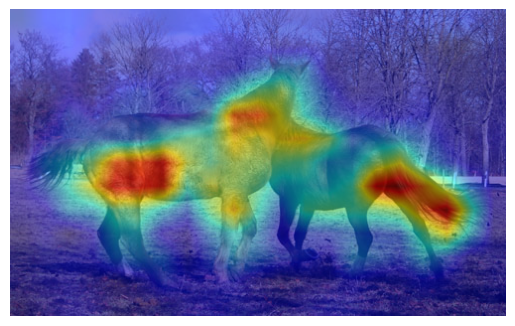

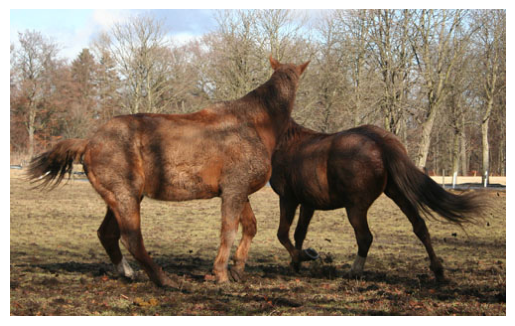

In [8]:
import torch
import torchvision
from PIL import Image
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

# List of COCO class names
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 
              'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 
              'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
              'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
              'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 
              'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 
              'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 
              'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 
              'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
              'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
              'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 
              'toothbrush']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2:]
    activations = []
    for _, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

def show_cam(image_path, class_name, detection_threshold=0.0):
    # Load and preprocess the image
    input_image = Image.open(image_path).convert("RGB")
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    input_tensor = transform(input_image).to(device).unsqueeze(0)

    # Run object detection
    outputs = model(input_tensor)
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_boxes = outputs[0]['boxes'].detach().cpu().numpy()
    pred_labels = outputs[0]['labels'].cpu().numpy()

    # Get the COCO class index
    class_index = coco_names.index(class_name)

    # Filter predictions by class and detection threshold
    filtered_boxes = [box for score, box, label in zip(pred_scores, pred_boxes, pred_labels) 
                      if score >= detection_threshold and label == class_index]

    if not filtered_boxes:
        print(f"No detections found for class '{class_name}' with score >= {detection_threshold}")
        return

    # Define CAM target
    current_labels = [class_index] * len(filtered_boxes)
    current_targets = [FasterRCNNBoxScoreTarget(labels=current_labels, bounding_boxes=filtered_boxes)]

    # Set up Grad-CAM
    target_layers = [model.backbone]
    cam = AblationCAM(
        model=model,
        target_layers=target_layers,
        reshape_transform=fasterrcnn_reshape_transform,
        ablation_layer=AblationLayerFasterRCNN(),
        ratio_channels_to_ablate=0.01
    )

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=current_targets)[0]

    # Overlay Grad-CAM on the image
    image_np = np.array(input_image, dtype=np.float32) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # Display the result
    plt.figure(1)
    plt.imshow(cam_image)
    plt.axis('Off')
    # plt.title(f"Class: {class_name}")
    plt.show()

    # Display the original image
    plt.figure(2)
    plt.imshow(input_image)
    plt.axis("Off")
    plt.show()

# Example usage
image_path = "../subdataset/subdataset/horse_2011_000840.jpg"  # Replace with the path to your image
class_name = "horse"  # Replace with the class name you want to visualize
show_cam(image_path, class_name)